# Vizualizações dos dados de acidentes de trânsito no Brasil

Dados extraídos do site da ANTT (Agência Nacional de Transportes Terrestres) e disponibilizados no site [Dados Abertos](https://dados.antt.gov.br/group/rodovias) do governo brasileiro.

Serão apenas considerados os dados dos últimos 5 anos, de 2019 a 2024.

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import calendar
import folium
from folium.plugins import HeatMap
import shapely

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Abrindo os dados

Os dados estão separados por concessíonárias.

In [3]:
dfs = {}
path = './data/acidentes'

for file in os.listdir(path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
        concessionaria = file.split('_')[2][:-4]
        dfs[concessionaria] = df

dfs

/tmp/ipykernel_1548388/816295864.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
/tmp/ipykernel_1548388/816295864.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
/tmp/ipykernel_1548388/816295864.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
/tmp/ipykernel_1548388/816295864.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(path, file), sep=';', encoding='latin1')
/tmp/ipykernel_1548388/816295864.py:6: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.rea

{'msvia':              data   horario  n_da_ocorrencia tipo_de_ocorrencia       km  \
 0      11/10/2014  12:21:00                6         sem vítima     92.1   
 1      11/10/2014  08:17:00              139         sem vítima      468   
 2      11/10/2014  08:34:00              149         com vítima      483   
 3      11/10/2014  06:36:00              287         sem vítima    289.1   
 4      11/10/2014  07:31:00              297         com vítima      295   
 ...           ...       ...              ...                ...      ...   
 15220  15/06/2024  09:45:29               13         Com vítima   90,624   
 15221  15/06/2024  10:17:01               20         Com vítima  427,000   
 15222  16/06/2024  03:29:00               67         Com vítima  461,254   
 15223  16/06/2024  05:38:39               96         Com vítima  511,790   
 15224  16/06/2024  12:25:31              154         Com vítima  270,508   
 
           trecho      sentido                  tipo_de_acidente 

## Filtrando os dados apenas de 2019 a 2024

In [4]:
# datas para datetime
new_dfs = []
for key, df in dfs.items():
    df['concessionaria'] = key
    df['data'] = pd.to_datetime(df['data'], format='%d/%m/%Y')
    df['data_hora'] = pd.to_datetime(df['data'].astype(str) + ' ' + df['horario'], format='%Y-%m-%d %H:%M:%S')
    df['com_vitima'] = True if df['tipo_de_ocorrencia'].str.contains('com').any() else False
    df.drop(columns=['tipo_de_ocorrencia','data','horario'], inplace=True)
    df = df[df['data_hora'].dt.year >= 2020]
    new_dfs.append(df)

new_dfs[0]

,n_da_ocorrencia,km,trecho,sentido,tipo_de_acidente,automovel,bicicleta,caminhao,moto,onibus,...,trator_maquinas,utilitarios,ilesos,levemente_feridos,moderadamente_feridos,gravemente_feridos,mortos,concessionaria,data_hora,com_vitima
8014,22,675.773,BR-163/MS,Sul,Saídas de pista,0,0,0,0,0,...,0,1,0,1,0,0,0,msvia,2020-01-01 05:06:00,True
8015,115,224.632,BR-163/MS,Norte,Capotamento,0,0,0,0,0,...,0,1,0,3,0,0,0,msvia,2020-01-01 12:42:00,True
8016,169,64.391,BR-163/MS,Sul,Capotamento,1,0,0,0,0,...,0,0,1,1,0,0,0,msvia,2020-01-01 04:05:00,True
8017,183,340.895,BR-163/MS,Norte,Engavetamento,3,0,0,0,0,...,0,0,8,0,0,0,0,msvia,2020-01-01 04:47:00,True
8018,259,452.19,BR-163/MS,Norte,Atropelamento de animais,1,0,0,0,0,...,0,0,4,0,0,0,0,msvia,2020-01-01 08:50:00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15220,13,"90,624",BR-163/MS,Decrescente,Queda de moto,0,0,0,1,0,...,0,0,0,0,0,0,0,msvia,2024-06-15 09:45:29,True
15221,20,"427,000",BR-163/MS,Crescente,Acidentes de outra natureza,1,0,0,0,0,...,0,0,0,0,0,0,0,msvia,2024-06-15 10:17:01,True
15222,67,"461,254",BR-163/MS,Decrescente,Acidentes de outra natureza,0,0,0,0,0,...,0,0,0,0,0,0,0,msvia,2024-06-16 03:29:00,True
15223,96,"511,790",BR-163/MS,Crescente,Acidentes de outra natureza,0,0,1,0,0,...,0,0,0,0,0,0,0,msvia,2024-06-16 05:38:39,True


## Concatenando os datasets

In [5]:
df_final = pd.concat(new_dfs, ignore_index=True)

print(df_final.info())
df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293344 entries, 0 to 293343
Data columns (total 23 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   n_da_ocorrencia                 293344 non-null  object        
 1   km                              293344 non-null  object        
 2   trecho                          293344 non-null  object        
 3   sentido                         293341 non-null  object        
 4   tipo_de_acidente                293102 non-null  object        
 5   automovel                       293344 non-null  int64         
 6   bicicleta                       293344 non-null  int64         
 7   caminhao                        293344 non-null  int64         
 8   moto                            293344 non-null  int64         
 9   onibus                          293344 non-null  int64         
 10  outros                          293344 non-null  int64  

,n_da_ocorrencia,km,trecho,sentido,tipo_de_acidente,automovel,bicicleta,caminhao,moto,onibus,...,trator_maquinas,utilitarios,ilesos,levemente_feridos,moderadamente_feridos,gravemente_feridos,mortos,concessionaria,data_hora,com_vitima
0,22,675.773,BR-163/MS,Sul,Saídas de pista,0,0,0,0,0,...,0,1,0,1,0,0,0,msvia,2020-01-01 05:06:00,True
1,115,224.632,BR-163/MS,Norte,Capotamento,0,0,0,0,0,...,0,1,0,3,0,0,0,msvia,2020-01-01 12:42:00,True
2,169,64.391,BR-163/MS,Sul,Capotamento,1,0,0,0,0,...,0,0,1,1,0,0,0,msvia,2020-01-01 04:05:00,True
3,183,340.895,BR-163/MS,Norte,Engavetamento,3,0,0,0,0,...,0,0,8,0,0,0,0,msvia,2020-01-01 04:47:00,True
4,259,452.19,BR-163/MS,Norte,Atropelamento de animais,1,0,0,0,0,...,0,0,4,0,0,0,0,msvia,2020-01-01 08:50:00,True


In [6]:
import re
def limpar_string(valor):
    if isinstance(valor, str): # apenas limpa oq não é possivel identificar como float, ou seja, contém algum erro
        valor_limpo = re.sub(r'[^\d.]', '', valor) 
        return valor_limpo
    return valor

# funcação necessária pq tinham valores com vírgula, ponto e erros grotescos como:
# "263+289" | "a675,812"

In [7]:
df_final['km'] = df_final['km'].apply(limpar_string)
df_final['km'] = df_final['km'].astype(float)
print("Tipo de dado da coluna 'km':",df_final['km'].dtype)
df_final.head()

Tipo de dado da coluna 'km': float64


,n_da_ocorrencia,km,trecho,sentido,tipo_de_acidente,automovel,bicicleta,caminhao,moto,onibus,...,trator_maquinas,utilitarios,ilesos,levemente_feridos,moderadamente_feridos,gravemente_feridos,mortos,concessionaria,data_hora,com_vitima
0,22,675.773,BR-163/MS,Sul,Saídas de pista,0,0,0,0,0,...,0,1,0,1,0,0,0,msvia,2020-01-01 05:06:00,True
1,115,224.632,BR-163/MS,Norte,Capotamento,0,0,0,0,0,...,0,1,0,3,0,0,0,msvia,2020-01-01 12:42:00,True
2,169,64.391,BR-163/MS,Sul,Capotamento,1,0,0,0,0,...,0,0,1,1,0,0,0,msvia,2020-01-01 04:05:00,True
3,183,340.895,BR-163/MS,Norte,Engavetamento,3,0,0,0,0,...,0,0,8,0,0,0,0,msvia,2020-01-01 04:47:00,True
4,259,452.190,BR-163/MS,Norte,Atropelamento de animais,1,0,0,0,0,...,0,0,4,0,0,0,0,msvia,2020-01-01 08:50:00,True


In [8]:
print("O DataFrame Final possui {} linhas e {} colunas".format(df_final.shape[0], df_final.shape[1]))

O DataFrame Final possui 293344 linhas e 23 colunas


## Plots

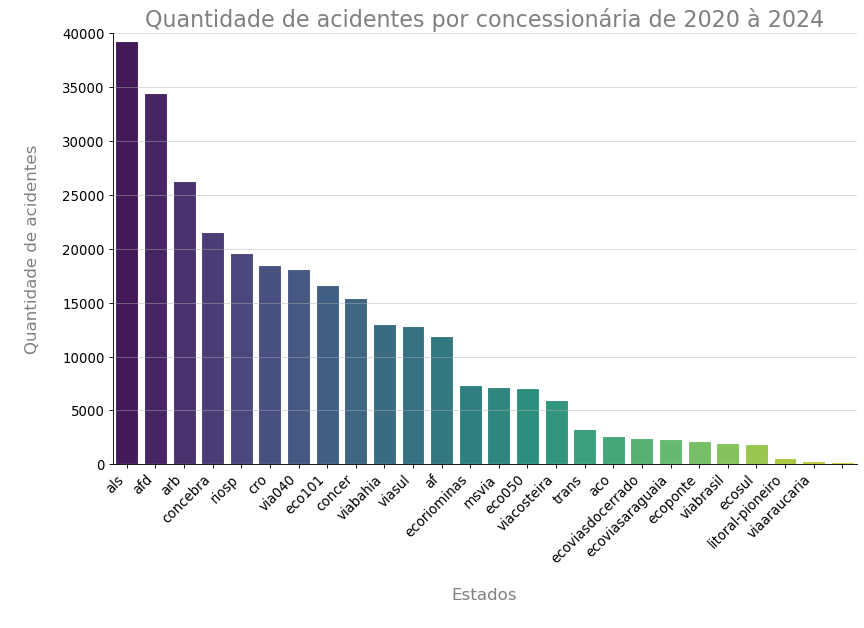

In [9]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

sns.set_theme(style='whitegrid')
ax = sns.barplot(x=df_final['concessionaria'].value_counts().index, 
                 y=df_final['concessionaria'].value_counts().values, 
                 palette='viridis')
plt.title('Quantidade de acidentes por concessionária de 2020 à 2024', fontsize=20, color='gray')

# total = df_final.shape[0]
# for i in ax.patches:
#     ax.text(i.get_x()+0.03, i.get_height() - 1500, 
#             str(round((i.get_height()/total)*100, 2))+"%", 
#             ha='center', 
#             fontsize=12,
#             weight='bold',
#             color='white')

plt.xlabel('\nEstados\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, 40000)

plt.grid(axis='y', alpha=0.5)

# for i in ['bottom', 'left']:
#     ax.spines[i].set_color('white')
#     ax.spines[i].set_linewidth(1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.savefig('./output/quantidade_acidentes_concessionaria.png', bbox_inches='tight', dpi=300, transparent=True)

In [10]:
df_final['estado'] = df_final['trecho'].str.split('/').str[1]
df_final.head(1)

,n_da_ocorrencia,km,trecho,sentido,tipo_de_acidente,automovel,bicicleta,caminhao,moto,onibus,...,utilitarios,ilesos,levemente_feridos,moderadamente_feridos,gravemente_feridos,mortos,concessionaria,data_hora,com_vitima,estado
0,22,675.773,BR-163/MS,Sul,Saídas de pista,0,0,0,0,0,...,1,0,1,0,0,0,msvia,2020-01-01 05:06:00,True,MS


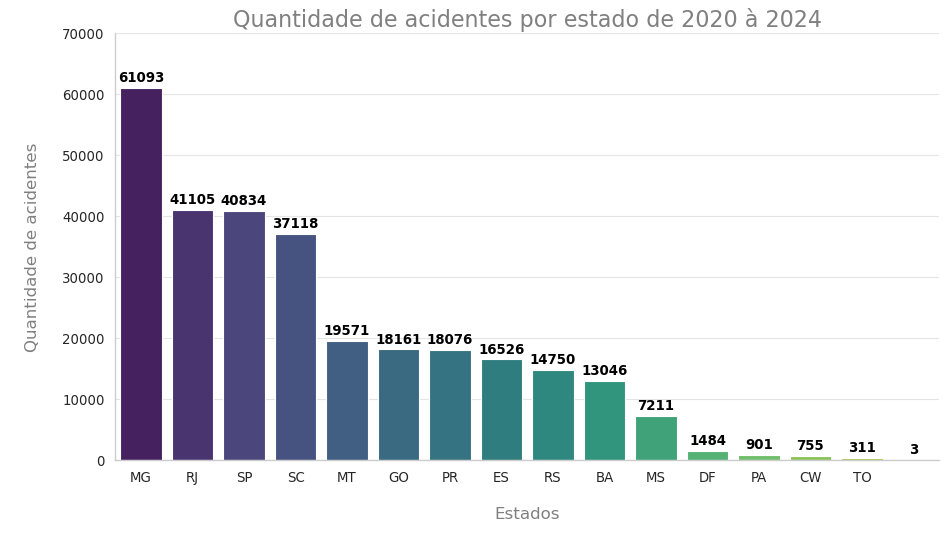

In [11]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

sns.set_theme(style='whitegrid')
ax = sns.barplot(x=df_final['estado'].value_counts().index, y=df_final['estado'].value_counts().values, palette='viridis')
plt.title('Quantidade de acidentes por estado de 2020 à 2024', fontsize=20, color='gray')


for i in ax.patches:
    ax.text(i.get_x()+0.4, i.get_height() + 1000, 
            str(int(i.get_height())), 
            ha='center', 
            fontsize=12,
            weight='bold',
            color='black')

plt.xlabel('\nEstados\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.ylim(0, 70000)

plt.grid(axis='y', alpha=0.5)

# for i in ['bottom', 'left']:
#     ax.spines[i].set_color('white')
#     ax.spines[i].set_linewidth(1.5)

right_side = ax.spines["right"]
right_side.set_visible(False)

top_side = ax.spines["top"]
top_side.set_visible(False)

plt.tight_layout()

plt.savefig('./output/quantidade_acidentes_estado.png', bbox_inches='tight', dpi=300, transparent=True)

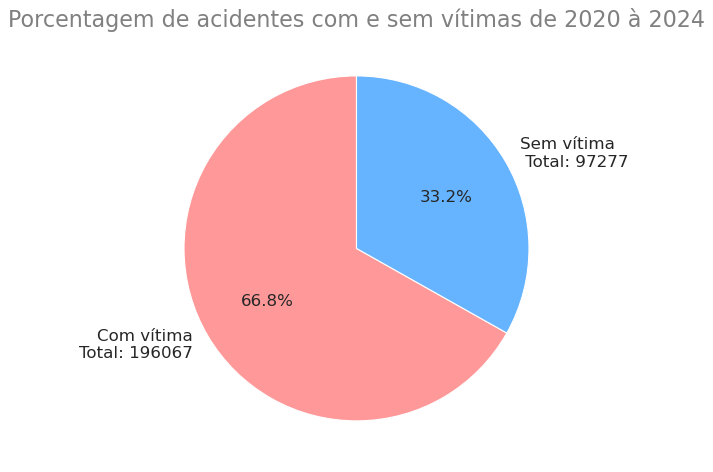

In [12]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

total_sem_vitimas = df_final['com_vitima'].sum()
total_vitimas = df_final.shape[0] - total_sem_vitimas

ax = plt.pie(df_final['com_vitima'].value_counts(), 
             labels=[ f'Com vítima\nTotal: {total_sem_vitimas}', f'Sem vítima\n Total: {total_vitimas}',], 
             autopct='%1.1f%%', 
             startangle=90, 
             colors=['#ff9999','#66b3ff'], 
             textprops={'fontsize': 15})

plt.title('Porcentagem de acidentes com e sem vítimas de 2020 à 2024', fontsize=20, color='gray')

plt.savefig('./output/porcentagem_acidentes_vitimas.png', bbox_inches='tight', dpi=300, transparent=True)

In [13]:
df_final['ano'] = df_final['data_hora'].dt.year

acidentes_com_vitima_ano = df_final.groupby(['ano', 'com_vitima']).size().unstack()
acidentes_com_vitima_ano

com_vitima,False,True
ano,,
2020,12764,40687
2021,15057,43691
2022,22113,43284
2023,30083,45020
2024,17260,23385


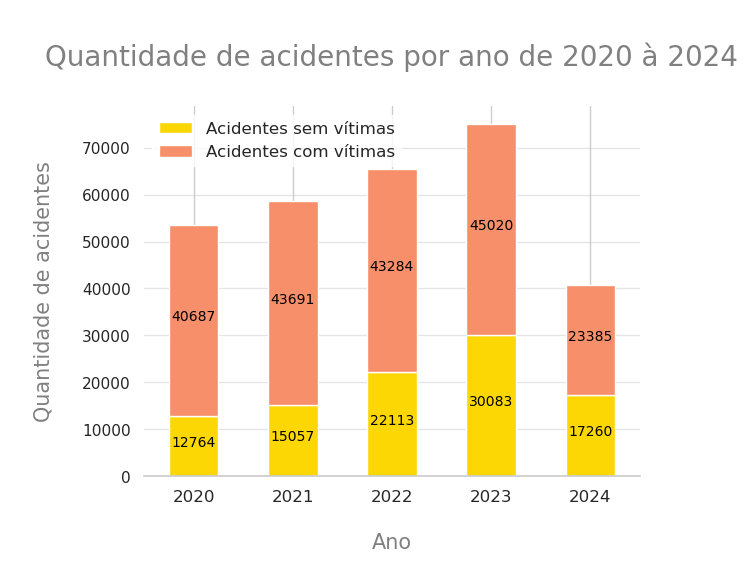

In [14]:
# ax = sns.barplot(x=df_final['data_hora'].dt.year.value_counts().index, 
#                  y=df_final['data_hora'].dt.year.value_counts().values, 
#                  color='#fcd703')

ax = acidentes_com_vitima_ano.plot(kind='bar', color=['#fcd703', '#f68f6a'], label='Acidentes com vítimas', stacked=True)

plt.title('\nQuantidade de acidentes por ano de 2020 à 2024\n', fontsize=20, color='gray')

for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.text(x+width/2, y+height/2, 
            str(int(height)), 
            ha='center', 
            fontsize=10,
            color='black')
    
for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

plt.xlabel('\nAno\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.xticks(fontsize=12, rotation=0)

plt.grid(axis='y', alpha=0.5)

plt.legend(['Acidentes sem vítimas','Acidentes com vítimas'], fontsize=12, edgecolor='white', fancybox=True, loc='best')

plt.savefig('./output/acidentes_por_ano.png', dpi=300, bbox_inches='tight')

In [ ]:
df_final['mes'] = df_final['data_hora'].dt.month
meses_do_ano = [calendar.month_abbr[i] for i in range(1, 13)]

acidentes_com_vitima_mes = df_final.groupby(['mes', 'com_vitima']).size().unstack()
acidentes_com_vitima_mes

com_vitima,False,True
mes,,
1,8148,20269
2,7505,16712
3,7871,16362
4,8882,15411
5,9580,15955
6,9126,16497
7,9217,16884
8,6598,14177
9,6744,14127


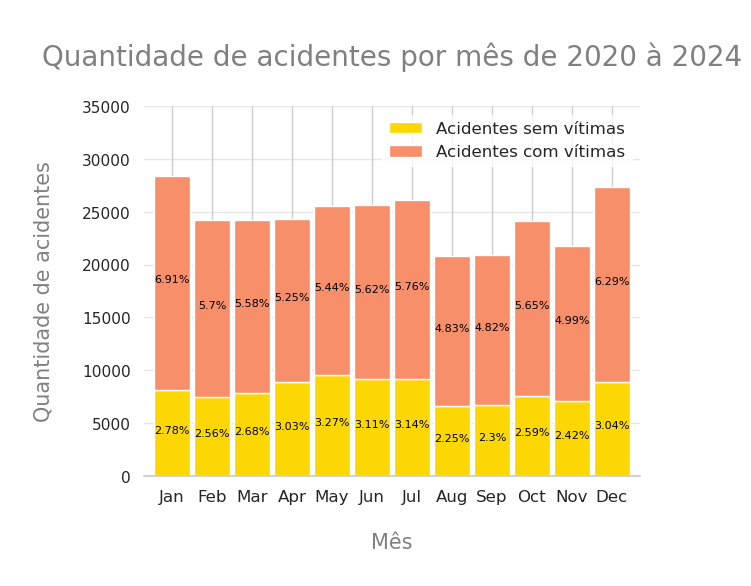

In [16]:
# ax = sns.barplot(x=df_final['data_hora'].dt.year.value_counts().index, 
#                  y=df_final['data_hora'].dt.year.value_counts().values, 
#                  color='#fcd703')

ax = acidentes_com_vitima_mes.plot(kind='bar', color=['#fcd703', '#f68f6a'], label='Acidentes com vítimas', stacked=True, width=0.9)

plt.title('\nQuantidade de acidentes por mês de 2020 à 2024\n', fontsize=20, color='gray')

total = df_final.shape[0]
for i in ax.patches:
    width, height = i.get_width(), i.get_height()
    x, y = i.get_xy()
    ax.text(x+width/2, y+height/2, 
            f'{round(height*100/total, 2)}%', 
            ha='center', 
            fontsize=8,
            color='black')
    
for i in ['top', 'left', 'right']:
    side = ax.spines[i]
    side.set_visible(False)

plt.xlabel('\nMês\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')

plt.grid(axis='y', alpha=0.5)

plt.ylim(0, 35000)

plt.xticks(range(0, 12), meses_do_ano, fontsize=12, rotation=0)

plt.legend(['Acidentes sem vítimas','Acidentes com vítimas'], fontsize=12, edgecolor='white', fancybox=True, loc='best')

plt.savefig('./output/acidentes_por_mes.png', dpi=300, bbox_inches='tight')

In [17]:
dia_semana_df = pd.DataFrame(df_final['data_hora'].dt.day_name().value_counts()).reset_index().rename(columns={'data_hora':'dia_semana'})
print(dia_semana_df.columns)

nome_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
dias_ordenados = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

dia_semana_df['dia_semana'] = pd.Categorical(dia_semana_df['dia_semana'], categories=dias_ordenados, ordered=True)
dia_semana_df = dia_semana_df.sort_values('dia_semana')
dia_semana_df['dia_semana'] = nome_dias
dia_semana_df

Index(['dia_semana', 'count'], dtype='object')


,dia_semana,count
3,Segunda-feira,41452
6,Terça-feira,37570
5,Quarta-feira,38336
4,Quinta-feira,39703
0,Sexta-feira,47642
1,Sábado,44714
2,Domingo,43927


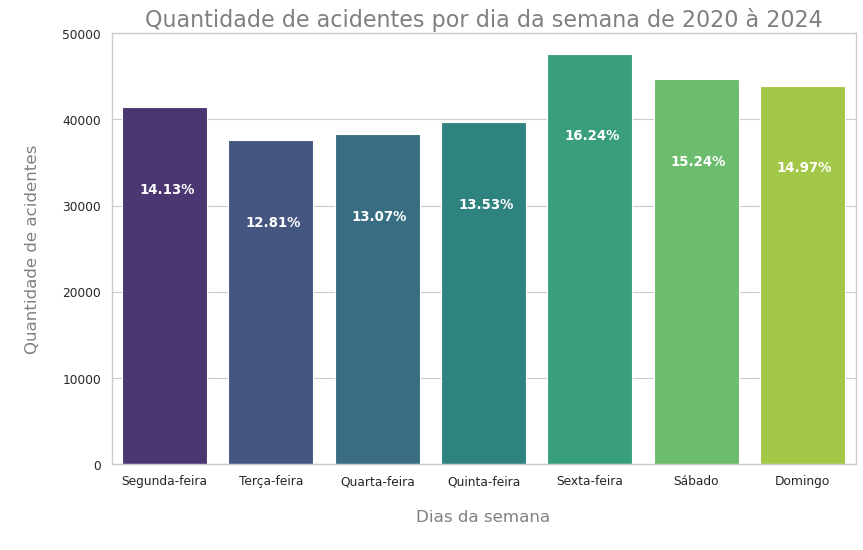

In [18]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

sns.set_theme(style='whitegrid')
ax = sns.barplot(x=dia_semana_df['dia_semana'], y=dia_semana_df['count'], palette='viridis')

total = df_final.shape[0]
for i in ax.patches:
    height = i.get_height()
    ax.text(i.get_x()+0.42, i.get_height() + -10000, 
            f'{round(height*100/total, 2)}%', 
            ha='center', 
            fontsize=12,
            weight='bold',
            color='white')

plt.title('Quantidade de acidentes por dia da semana de 2020 à 2024', fontsize=20, color='gray')
plt.xlabel('\nDias da semana\n', fontsize=15, color='gray')
plt.ylabel('\nQuantidade de acidentes\n', fontsize=15, color='gray')
# plt.xticks(range(0, 7), nome_dias, fontsize=12)
plt.savefig('./output/quantidade_acidentes_dia_semana.png', bbox_inches='tight', dpi=300, transparent=True)

In [19]:
hora_df = pd.DataFrame(df_final['data_hora'].dt.hour.value_counts()).reset_index().rename(columns={'data_hora':'hora'}).sort_values('hora')
print(hora_df.columns)
df_final['data_hora'].dt.hour.value_counts()
print(df_final.shape[0], hora_df['count'].sum())

Index(['hora', 'count'], dtype='object')
293344 293344


/tmp/ipykernel_1548388/986395835.py:12: UserWarning: The palette list has more values (24) than needed (12), which may not be intended.
  ax = sns.barplot(x=hora_df['hora'], y=hora_df['count'], palette=cores)


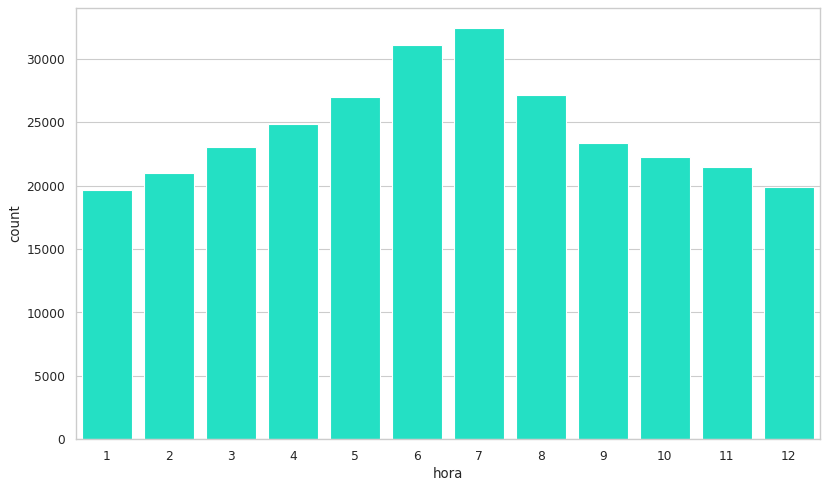

In [20]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=80)

cores = []
for i in range(24):
    if i >= 0 and i < 12:
        cores.append('#05ffda')
    elif i >= 12 and i < 18:
        cores.append('#2426b3')
    else:
        cores.append('#fcd703')

ax = sns.barplot(x=hora_df['hora'], y=hora_df['count'], palette=cores)
plt.show()

## Cruzando com as pistas para pegar as posições geográficas

*Feito em outro notebook, apenas copiando o código*

In [21]:
pista_principal_df = pd.read_csv('data/km_pista_principal/dados_dos_quilometro_principal.csv', sep=';', encoding='latin1')
pista_principal_df['latitude'] = pista_principal_df['latitude'].str.replace(',', '.').astype(float)
pista_principal_df['longitude'] = pista_principal_df['longitude'].str.replace(',', '.').astype(float)
pista_principal_df['km_m'] = pista_principal_df['km_m'].str.replace(',', '.').astype(float)
pista_principal_df = pista_principal_df.rename(columns={'km_m':'km'})
pista_principal_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255127 entries, 0 to 255126
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   concessionaria  255127 non-null  object 
 1   ano_do_pnv_snv  255127 non-null  int64  
 2   rodovia         255127 non-null  object 
 3   km              255127 non-null  float64
 4   sentido         255127 non-null  object 
 5   latitude        255127 non-null  float64
 6   longitude       255127 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 13.6+ MB


In [22]:
def arredondar_par(num):
    arredondado = round(num, 1)
    # Verifica se é ímpar e ajusta
    return arredondado + (1 if arredondado > 0 and arredondado % 2 != 0 else -1 if arredondado < 0 and arredondado % 2 != 0 else 0)

# Aplicar a função de arredondamento para a coluna 'km' do DataFrame df_final
df_final['km_arredondado'] = df_final['km'].apply(arredondar_par)

# Mesclar df_final com pista_principal_df usando a coluna 'rodovia' e 'km_arredondado'
df_merge = pd.merge(df_final, pista_principal_df, left_on=['trecho', 'km_arredondado'], right_on=['rodovia', 'km'], how='left', suffixes=('', '_localizacao'))

# Atualizar latitude e longitude no df_final
df_final['latitude'] = df_merge['latitude']
df_final['longitude'] = df_merge['longitude']

# Remover a coluna auxiliar
df_final.drop(columns=['km_arredondado'], inplace=True)

# Exibir as primeiras linhas do DataFrame atualizado
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 293344 entries, 0 to 293343
Data columns (total 28 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   n_da_ocorrencia                 293344 non-null  object        
 1   km                              293344 non-null  float64       
 2   trecho                          293344 non-null  object        
 3   sentido                         293341 non-null  object        
 4   tipo_de_acidente                293102 non-null  object        
 5   automovel                       293344 non-null  int64         
 6   bicicleta                       293344 non-null  int64         
 7   caminhao                        293344 non-null  int64         
 8   moto                            293344 non-null  int64         
 9   onibus                          293344 non-null  int64         
 10  outros                          293344 non-null  int64  

In [23]:
geometry = [Point(xy) for xy in zip(df_final['longitude'], df_final['latitude'])]

NameError: name 'Point' is not defined